[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2853
[LightGBM] [Info] Number of data points in the train set: 340, number of used features: 25
[LightGBM] [Info] Start training from score -0.408411
[LightGBM] [Info] Start training from score -1.670063
[LightGBM] [Info] Start training from score -2.610070
[LightGBM] [Info] Start training from score -2.610070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

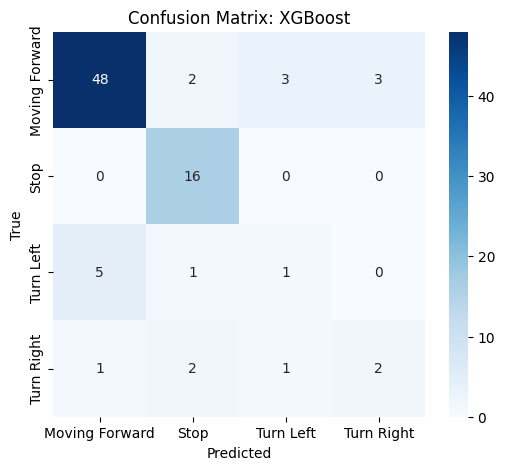


=== LightGBM ===
Accuracy: 0.84
Classification Report:
                precision    recall  f1-score   support

Moving Forward       0.87      0.95      0.91        56
          Stop       0.80      1.00      0.89        16
     Turn Left       0.00      0.00      0.00         7
    Turn Right       0.67      0.33      0.44         6

      accuracy                           0.84        85
     macro avg       0.58      0.57      0.56        85
  weighted avg       0.77      0.84      0.80        85



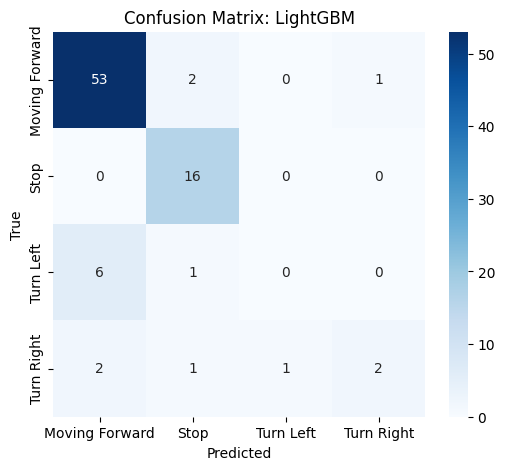


=== CatBoost ===
Accuracy: 0.81
Classification Report:
                precision    recall  f1-score   support

Moving Forward       0.88      0.89      0.88        56
          Stop       0.76      1.00      0.86        16
     Turn Left       0.50      0.14      0.22         7
    Turn Right       0.40      0.33      0.36         6

      accuracy                           0.81        85
     macro avg       0.63      0.59      0.58        85
  weighted avg       0.79      0.81      0.79        85



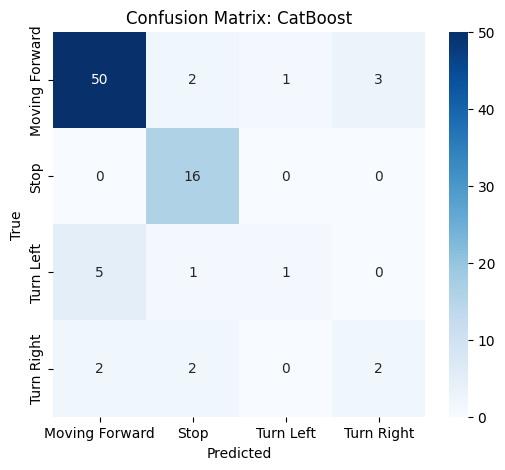

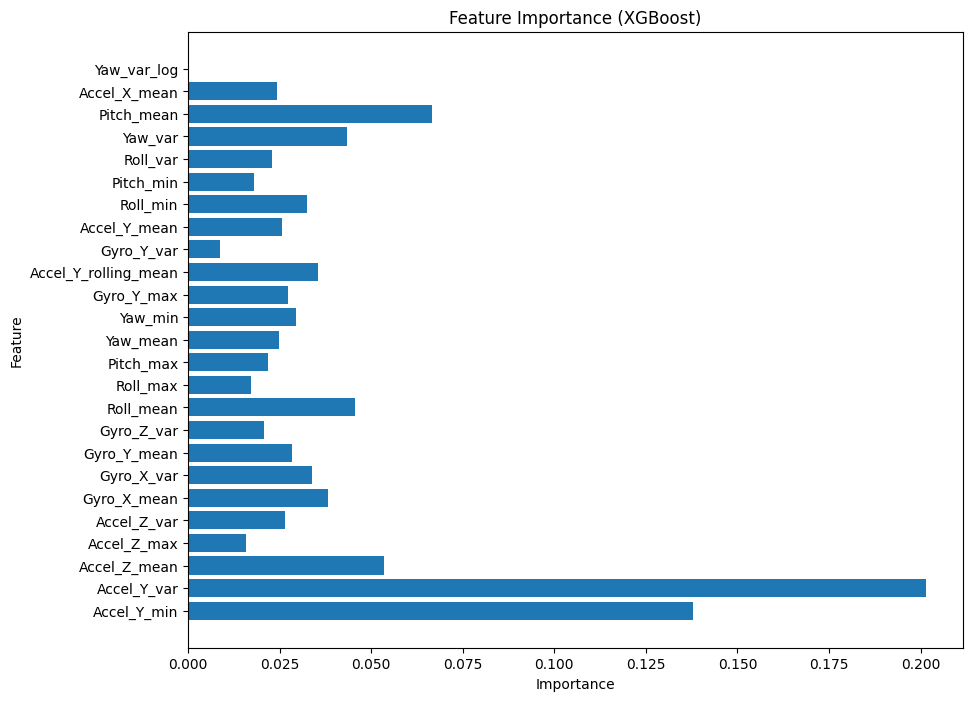

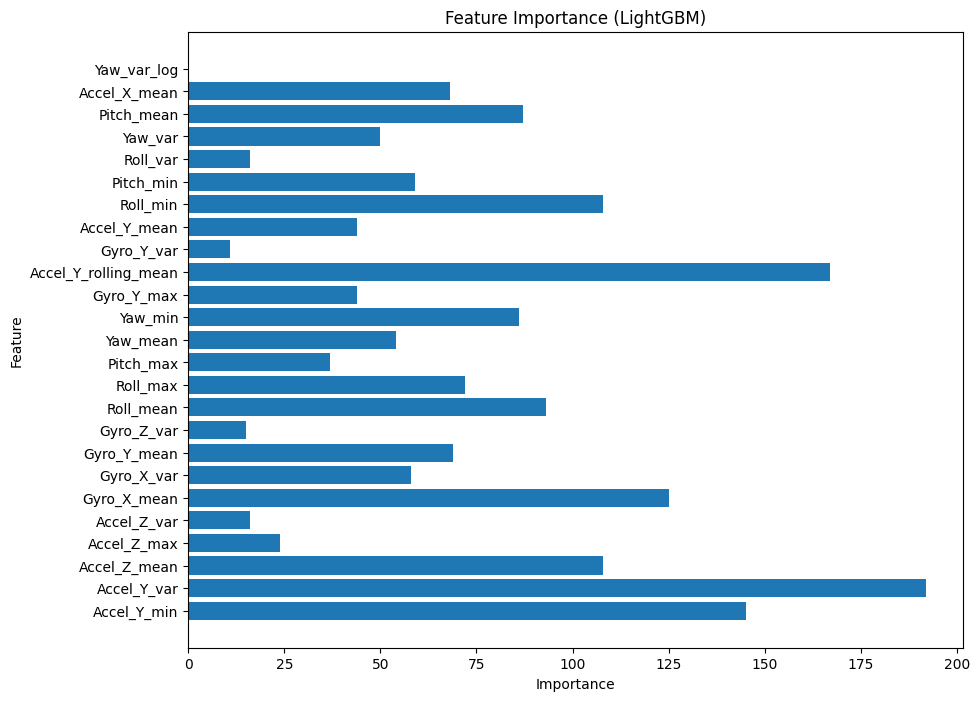

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder

# Step 1: Load Preprocessed Data
data = pd.read_csv('../data-collection/2024-12-10_22-37-46_Data/updated_processed_data.csv')

# Separate features and target
X = data.drop(columns=['Label'])
y = data['Label']

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert labels to numerical format

# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Train Gradient Boosting Models
# Model 1: XGBoost
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Model 2: LightGBM with Early Stopping
lgbm_model = LGBMClassifier(
    random_state=42,
    num_leaves=31,
    max_depth=6,
    learning_rate=0.05,
    min_child_samples=20
)

# Use callbacks for early stopping in LightGBM
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(10)
    ]
)

# Model 3: CatBoost
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# Step 4: Evaluate Models
models = {
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model,
    'CatBoost': catboost_model
}

for model_name, model in models.items():
    print(f"\n=== {model_name} ===")

    # Predictions
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Step 5: Plot Feature Importance (Optional)
# Plot for XGBoost
plt.figure(figsize=(10, 8))
plt.barh(X.columns, xgb_model.feature_importances_)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Plot for LightGBM
plt.figure(figsize=(10, 8))
plt.barh(X.columns, lgbm_model.feature_importances_)
plt.title("Feature Importance (LightGBM)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## Comparison of Gradient Boosting Models

### Models Compared
1. **XGBoost**
2. **LightGBM**
3. **CatBoost**

### Summary of Results
| Model      | Accuracy | Precision (Macro Avg) | Recall (Macro Avg) | F1-Score (Macro Avg) |
|------------|----------|------------------------|---------------------|-----------------------|
| XGBoost    | 0.79     | 0.56                   | 0.58                | 0.57                  |
| LightGBM   | 0.84     | 0.58                   | 0.57                | 0.56                  |
| CatBoost   | 0.81     | 0.63                   | 0.59                | 0.58                  |

### Observations
1. **Accuracy**:
   - LightGBM achieved the highest accuracy (0.84).
   - XGBoost and CatBoost were slightly lower, at 0.79 and 0.81, respectively.

2. **Handling Imbalanced Data**:
   - CatBoost demonstrated a better balance across classes as indicated by its higher macro F1-score (0.58).
   - XGBoost struggled with minority classes (`Turn Left` and `Turn Right`), evident from its low recall for these classes.

3. **Feature Importance**:
   - All models identified `Accel_Y_min` and `Accel_Y_var` as the most important features, but their respective feature rankings differed slightly.
   - LightGBM and XGBoost provided consistent feature importance distributions, while CatBoost's feature contribution could be analyzed separately.

### Next Steps
- Proceed with **LightGBM** as it demonstrated the highest accuracy, but adjust for imbalanced labels using class weights or advanced resampling techniques.
- Hyperparameter tuning for LightGBM could potentially enhance minority class performance (`Turn Left` and `Turn Right`).
- Consider ensemble methods combining all three models for further improvements.

---

## LightGBM with Class Weights and Hyperparameter Tuning

The next script will focus on LightGBM, incorporating:
1. **Class Weights**: To address class imbalance.
2. **Hyperparameter Tuning**: To optimize the model for better performance on minority classes.

### Suggested Script Name
`tune_lightgbm_with_class_weights.ipynb`

---

This structure ensures you document your current findings and set the context for the next steps. Let me know if you need assistance documenting or creating the next script!
